In [35]:
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

torch.manual_seed(101);

In [2]:
train_data = datasets.MNIST(
    root = "../datasets/",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
    root = '../datasets/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

d:\Codehub\dl-medical\env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10,shuffle=False)

In [5]:
def loader_info(loader: DataLoader) -> None:
    print(f"Number of Batches: {len(loader)}")
    print(f"Size of each batch: {loader.batch_size}\n")

In [6]:
loader_info(train_loader)
loader_info(test_loader)

Number of Batches: 6000
Size of each batch: 10

Number of Batches: 1000
Size of each batch: 10



## Convolution
It's like feature extraction but for image

In [7]:
# 1 COLOR CHANNEL, 6 FILTERS (OUTPUT CHANNELS), 3x3 KERNEL, STRIDE=1 
# For instance, (1,28,28) image, applying 6 filters of 3x3 over it would yeild, 6x26x6 as output
conv1 = nn.Conv2d(1,6,3,1) 

# 6 Input Filters Conv1, 16 filters, 3x3 KERNEL, stride = 1 
# The instance image with dimension 6x26x26 is fed into the 2nd conv layer
conv2 = nn.Conv2d(6,16,3,1)

In [8]:
for i, (X_train, y_train) in enumerate(train_data):
    break
X_train.shape

torch.Size([1, 28, 28])

In [9]:
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [10]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

## Pooling
Reduce the number of parameters to prevent overfitting

In [11]:
# Input, 2x2 kernel, stride = 2
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [12]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [13]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

Flatten before feeding into Fully Connected Neural Network

In [14]:
x.reshape(-1,16*5*5).shape

torch.Size([1, 400])

In [15]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,16*5*5)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [16]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
print(f'# of parameters: {sum([p.numel() for p in model.parameters()])}')

# of parameters: 60074


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [19]:
import time

start = time.time()

epochs = 5
train_loss = []
test_loss = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1

        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)

        predicted = torch.max(y_pred.data,1)[1]
        batch_correct = (predicted == y_train).sum()
        train_corr +=batch_correct

        optimizer.zero_grad() # Reset gradients
        loss.backward() # Perform backpropogation
        optimizer.step() # Update parameters with optimized weights

        if b%600 == 0:
            accuracy = train_corr.item()*100/(10*b)
            clear_output(wait=True)
            print(f'[Epoch {i}] Batch {b} | loss: {loss.item()} | accuracy: {accuracy}%')
    
    train_loss.append(loss.item())
    train_correct.append(train_corr.item())

    with torch.no_grad(): # Disable gradient tracking
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            test_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val,y_test)
    test_loss.append(loss)
    test_correct.append(test_corr)
    
total_time = time.time() - start
print(f"Duration: {total_time/60} mins")

[Epoch 4] Batch 6000 | loss: 0.0024646713864058256 | accuracy: 99.02333333333333%
Duration: 3.364368744691213


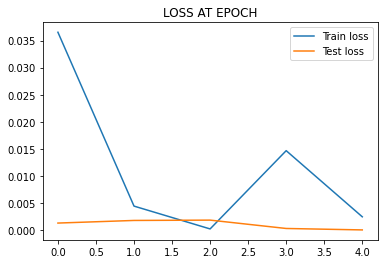

In [20]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.title('LOSS AT EPOCH')
plt.legend()

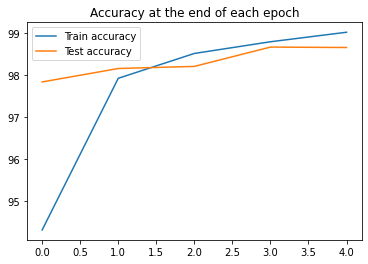

In [24]:
plt.plot([t/60000*100 for t in train_correct], label = 'Train accuracy')
plt.plot([t/10000*100 for t in test_correct], label = 'Test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [27]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
loader_info(test_load_all)

Number of Batches: 1
Size of each batch: 10000



In [28]:
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        y_val = model(X_test)
        loss = criterion(y_val,y_test)

        predicted = torch.max(y_val.data,1)[1]
        correct+=(predicted == y_test).sum()

In [32]:
print(f"New Test Accuracy: {(correct.item()/10000*100)}%")

New Test Accuracy: 98.66%


In [36]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 975    0    3    0    0    2    5    1    6    0]
 [   0 1131    3    0    0    0    2    6    0    0]
 [   2    1 1016    0    0    0    1    6    3    0]
 [   0    1    3 1005    0   21    0    1    1    0]
 [   0    0    1    0  973    0    2    4    0    8]
 [   0    0    0    1    0  861    0    0    0    4]
 [   2    2    0    0    6    4  947    0    0    0]
 [   1    0    6    2    0    0    0 1004    1    2]
 [   0    0    0    2    0    1    1    2  961    2]
 [   0    0    0    0    3    3    0    4    2  993]]


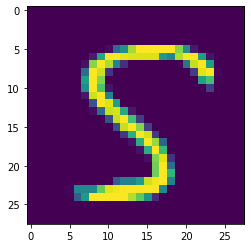

In [50]:
plt.imshow(test_data[333
][0].reshape(28,28))

In [48]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[333][0].view(1,1,28,28))

In [49]:
torch.argmax(new_pred)

tensor(5)